In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 6
import scipy.io as sio
from scipy import fft, arange, signal


from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.tools import diff

In [2]:
df2 = pd.read_csv('h.264+mp3_TS.csv')

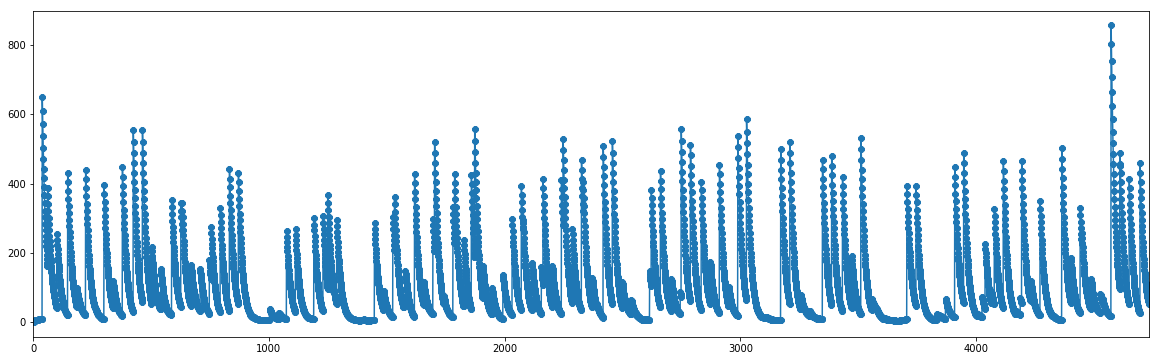

In [5]:
df2['Jitter'].plot(marker='8')
#plot the data

In [29]:
from statsmodels import api as sm

Text(0, 0.5, 'Jitter')

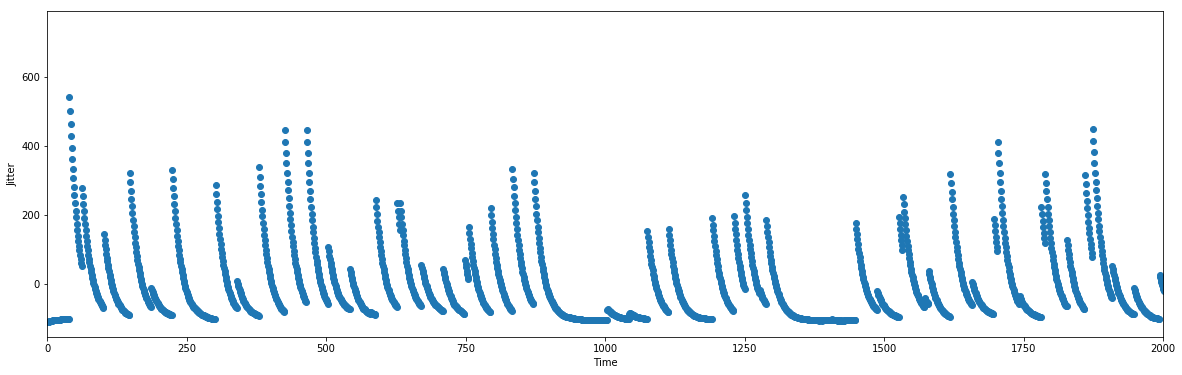

In [62]:
#df2
temp_df2 = np.array([x for x in df2['Jitter']])

temp_df2_n = temp_df2 - np.mean(temp_df2)

t1 = arange(len(temp_df2_n)) + 1

# let's plot the data
plt.plot(t1, temp_df2_n,'o')
plt.xlim(0,2000)
plt.xlabel('Time')
plt.ylabel('Jitter')

Text(0, 0.5, 'Autocorrelation')

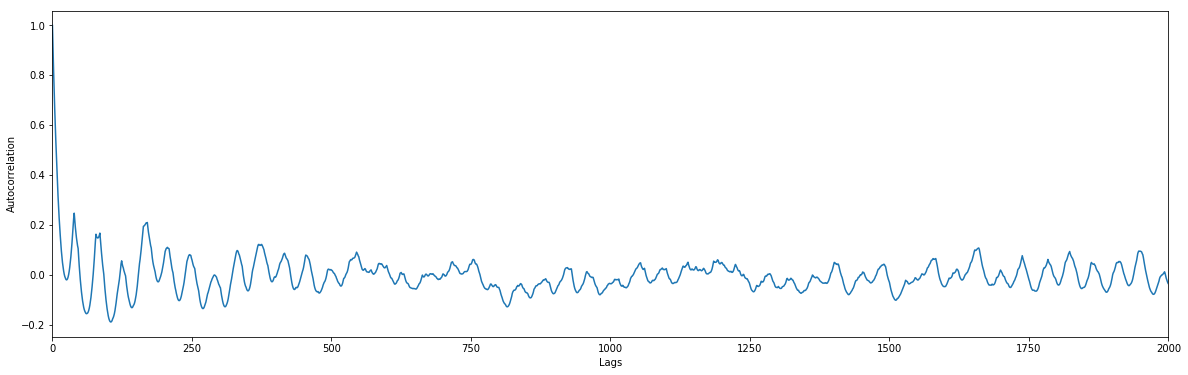

In [36]:
# get the autocorrelation coefficient
acf_df2 = sm.tsa.acf(temp_df2_n, nlags=len(temp_df2_n))

lag_df2 = arange(len(temp_df2_n))
plt.plot(lag_df2, acf_df2)
plt.xlim((0, 2000))
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

In [76]:
# find all the peaks that associated with the positive peaks
peaks_positive, _ = signal.find_peaks(acf_df2, height=0.0, threshold=None)

Text(0, 0.5, 'Autocorrelation')

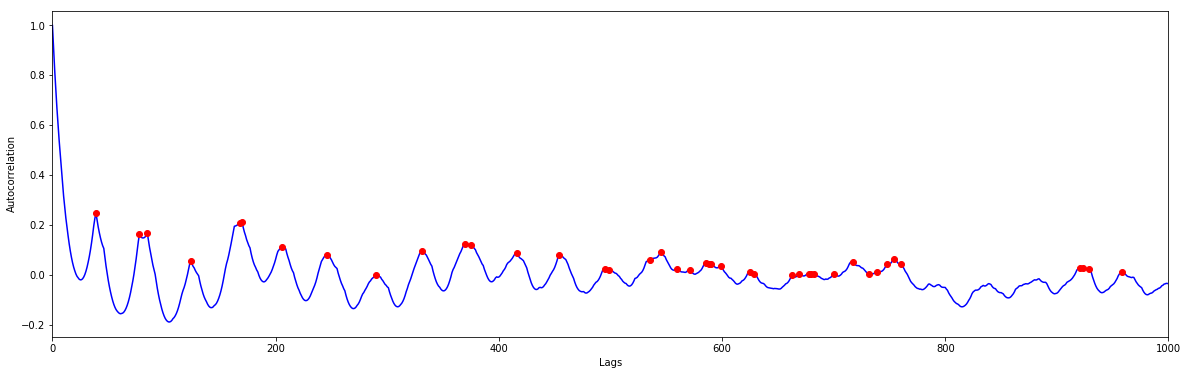

In [78]:
plt.plot(lag_df2, acf_df2, 'b-')

plt.plot(lag_df2[peaks_positive], acf_df2[peaks_positive], 'ro')
plt.xlim((0, 1000))
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

In [50]:
#actual data

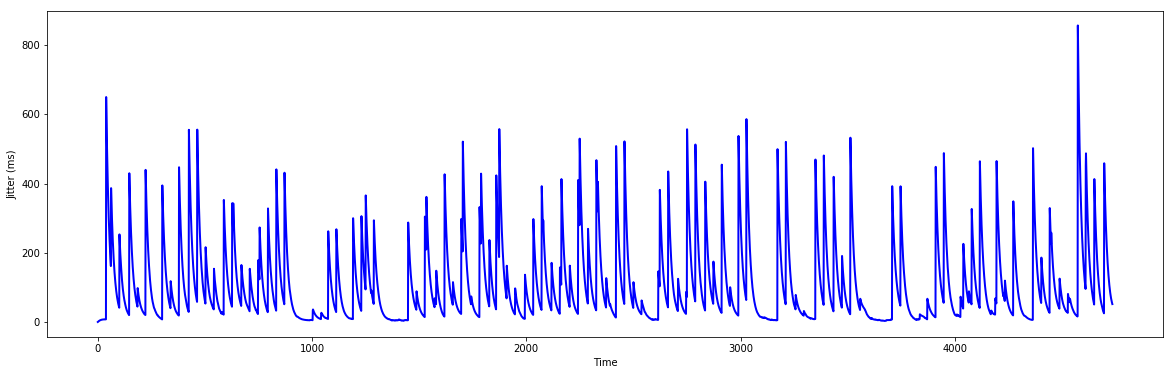

In [51]:
plt.plot(df2.Time, df2.Jitter, 'b-', linewidth = 2)
plt.xlabel('Time')
plt.ylabel('Jitter (ms)')
plt.show()

In [52]:
# find all the peaks that associated with the positive peaks
peaks_ , _ = signal.find_peaks(df2.Jitter, threshold = None, distance=None)

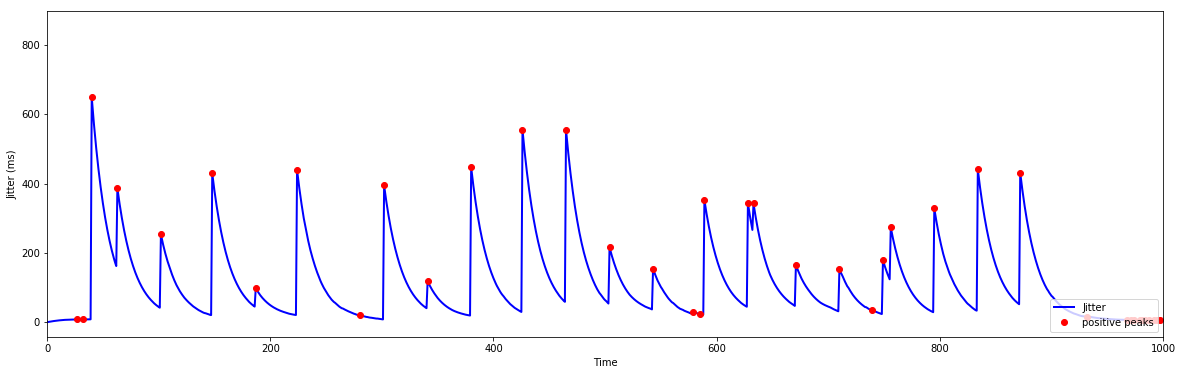

In [56]:
plt.plot(df2.Time, df2.Jitter, 'b-', linewidth = 2)

plt.plot(df2.Time[peaks_], df2.Jitter[peaks_], 'ro', label = 'positive peaks')

plt.xlabel('Time')
plt.ylabel('Jitter (ms)')
plt.xlim((0, 1000))
plt.legend(loc = 4)
plt.show()

In [65]:
peaks_[2:6]
#Peak indexes

array([ 39,  62, 101, 147], dtype=int64)

## Period estimation 

In [68]:
#With this, we can calculate the period of the signal by taking the diff of the peak indexes
np.diff(peaks_)[2:10]

array([23, 39, 46, 39, 37, 56, 22, 39], dtype=int64)

## Obtain an array of the values 

In [7]:
x = df2.Time.values
y = df2.Jitter.values

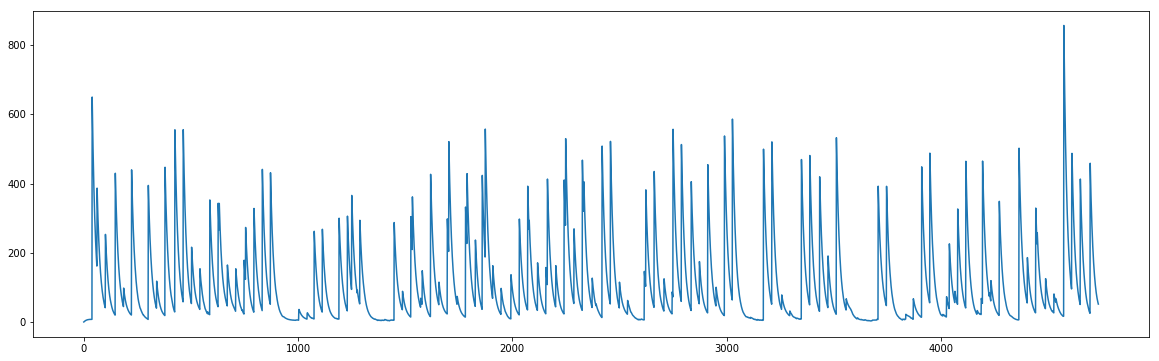

In [13]:
plt.plot(x,y)

Polynomial fitting to a subset of the data. Here the x and y values are the first 200 timepoints.

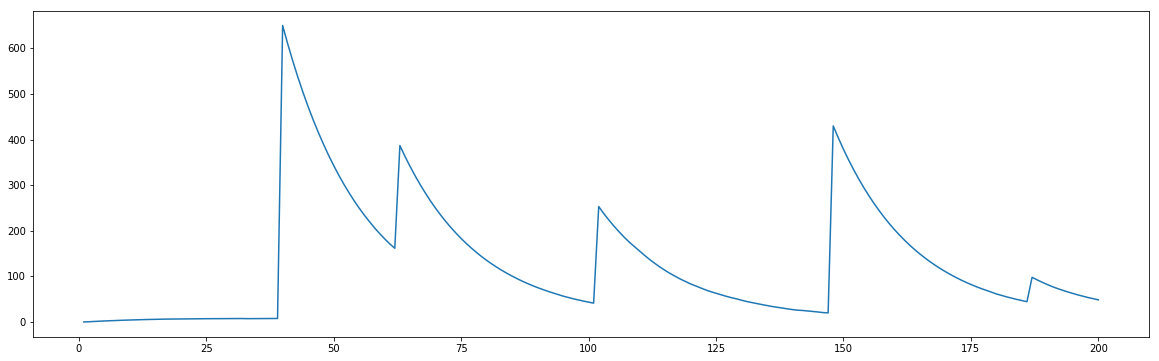

In [61]:
x1 = x[:200]
y1 = y[:200]
plt.plot(x1,y1)

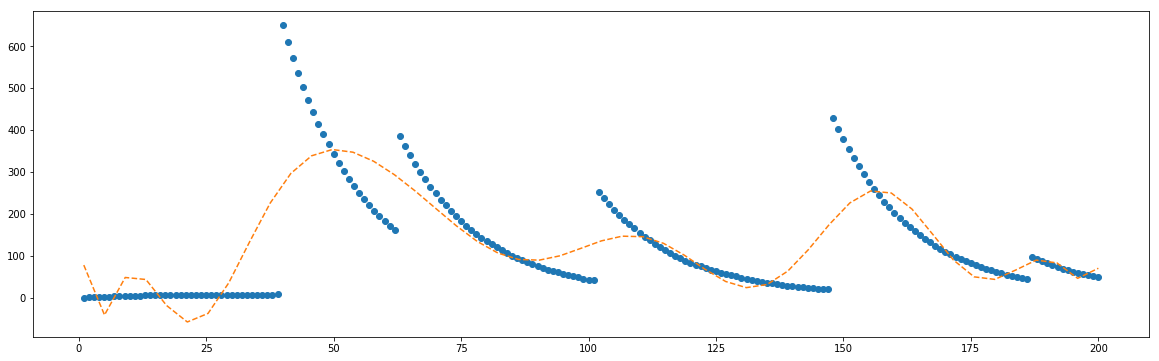

In [62]:
c = np.polyfit(x1,y1,15)
x1fit = np.linspace(x1.min(), x1.max())

y1fit = np.polyval(c,x1fit)
plt.plot(x1,y1,'o', x1fit,y1fit,'--');

## Data not a fit polynomial regression
As can be seen from the plot above, even with an n value of 100, the data is rather a poor fit for polynomial regression.

## Exponential model

In [19]:
f = y

We model the data with the fitting function that consists of a quadratic polynomial background with a Gaussian peak:

A(f) = a + bf + cf^2 + P e^{-\frac{1}{2}[(f-f_p)/f_w]^2} .

The block of code below define the fitting functions. Note that the independent variable f is the first argument, which is followed by the six fitting parameters a, b, c, P, {f_p}, and f_w.

In [58]:
#We fit the data using  fit data using SciPy's Levenberg-Marquart method

In [59]:
from scipy.optimize import curve_fit

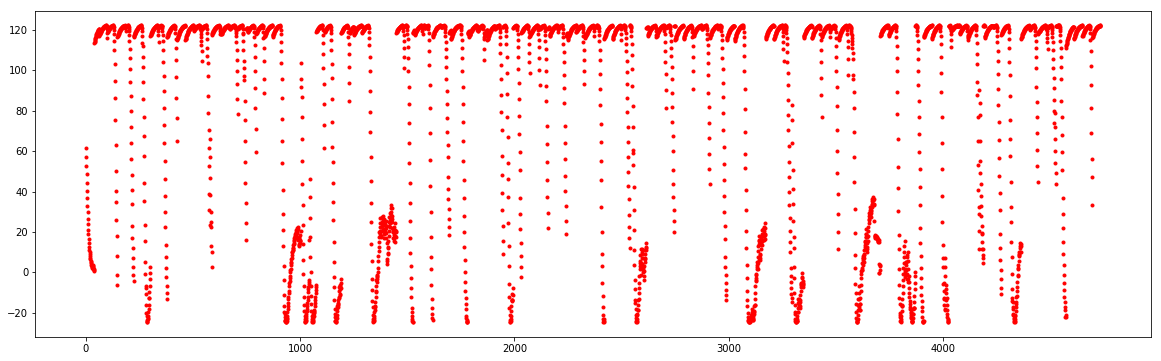

In [55]:
def f2(f, a, b, c, P, fp, fw):
    return a + b*f + c*f*f + P*np.exp(-0.5*((f-fp)/fw)**2)

# initial guesses for fitting parameters
a0, b0, c0 = -80., 0.08, 0.18
P0, fp0, fw0 = 15., 22., 2.

'''
Realized an R-square of 33.3% with these parameters

a0, b0, c0 = 3., 7., 5.
P0, fp0, fw0 = 10., 23., 22.
'''

#a0, b0, c0 = 60., -3., 0.
#P0, fp0, fw0 = 80., 11., 2.

# fit data using SciPy's Levenberg-Marquart method
c, cov = curve_fit(f2,
                x, f, p0=[a0, b0, c0, P0, fp0, fw0])

# unpack fitting parameters
a, b, c, P, fp, fw = c


plt.plot(x, f2(f, a, b, c, P, fp, fw), 'r.', label='fit')

#plt.plot(x, y, 'bo')

## Plot of the predicted values above

## let's obtain the R-squared of the fit -- 21% (poor fit)

In [56]:
from sklearn.metrics import r2_score
print('R^2: ', r2_score(y, f2(y, a, b, c, P, fp, fw))*100)

R^2:  20.652277297065613


In [57]:
params = [a, b, c, P, fp, fw]
for i in params:
    print (i)

123.16567909219773
-0.017109991305632843
3.6535747805727e-06
-147.43369493205725
14.268536594223065
10.787527251832152


## From tweaking the parameters, I was able to realize an R-squared value of 33.3% which isn't an ideal fit to the dataset. At the moment, the R-sq is just about 20%.

I have been trying to fine-tune the model which I believe it's the issue but haven't been able to realize a better fit.